## Initial imports

In [1]:
from scm.libbase import ChemicalSystem
from scm.plams import AMSJob, Settings, view

## System

In [2]:
cs = ChemicalSystem(
    """
System
    Atoms
        O 1.48603879 -1.49561627 0.0 
        C 1.29751002 -0.30552432 0.0 
        O 0.07403584000000001 0.25228979 0.0 
        C -1.02449892 -0.67494471 0.0 
        C -2.30056502 0.12358769 0.0 
        C 2.36905363 0.74347075 0.0 
        H -0.9418758699999999 -1.31519741 0.88039373 
        H -0.9418758699999999 -1.31519741 -0.88039373 
        H -2.36617127 0.7582087199999999 0.88525259 
        H -3.15628689 -0.55419212 0.0 
        H -2.36617127 0.7582087199999999 -0.88525259 
        H 3.34355252 0.26293272 0.0 
        H 2.26362714 1.38098693 0.87932777 
        H 2.26362714 1.38098693 -0.87932777 
    End
End
"""
)

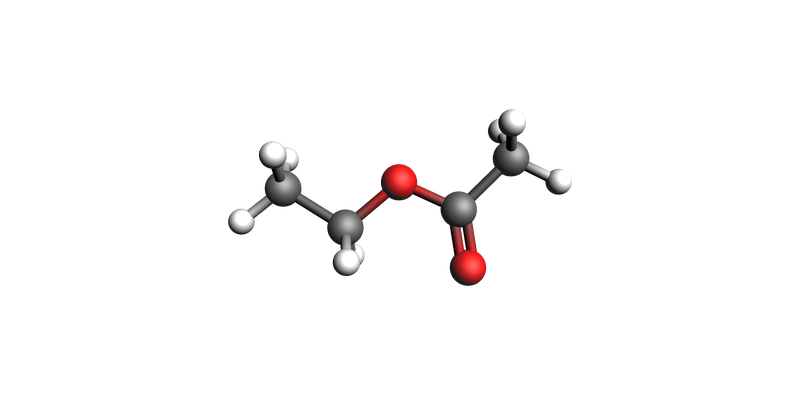

In [3]:
# visualize system with bonds
cs_with_bonds = cs.copy()
cs_with_bonds.guess_bonds()
view(cs_with_bonds)

## Job settings: DFT and NMR

There are three calculations:

1. A DFT calculation with a main results file ``adf.rkf``. We must set the ``Save TAPE10`` input option. The ``TAPE10`` file is later used by the ``$AMSBIN/nmr`` program.

2. An ``$AMSBIN/cpl`` calculation. This program *modifies* ``adf.rkf``

3. An ``$AMSBIN/nmr`` calculation. This program reads ``TAPE10`` and *modifies* ``adf.rkf``.

In the end, all results are stored on ``adf.rkf``.

There is no PLAMS job for the ``$AMSBIN/cpl`` and ``$AMSBIN/nmr`` programs. Instead, we set up the calculation explicitly in the ``settings.runscript.postamble_lines`` option.

In [4]:
# DFT Settings
s = Settings()
s.input.ams.Task = "SinglePoint"
s.input.adf.Basis.Type = "TZ2P-J"
s.input.adf.Basis.Core = "None"
s.input.adf.Save = "TAPE10"
s.input.adf.xc.GGA = "OPBE"
s.input.adf.Symmetry = "NOSYM"
s.input.adf.NumericalQuality = "Good"

In [5]:
from typing import Mapping, List


def get_cpl_script(s: Mapping) -> List[str]:
    ret = (
        ['"$AMSBIN/cpl" <<eor']
        + ["ADFFile adf.rkf"]
        + ["NMRCOUPLING"]
        + [f"  {k} {v}" for k, v in s.items()]
        + ["END"]
        + ["eor"]
        + [""]
    )
    return ret


def get_nmr_script(s: Mapping) -> List[str]:
    ret = (
        ['"$AMSBIN/nmr" <<eor']
        + ["ADFFile adf.rkf", "TAPE10File TAPE10"]
        + ["NMR"]
        + [f"  {k} {v}" for k, v in s.items()]
        + ["End"]
        + ["eor"]
        + [""]
    )
    return ret


cpl_settings = dict(RespAllAtomsOfType="H", PertAllAtomsOfType="H", fc="", ADFGUI="")
nmr_settings = dict(out="", adfgui="", AllAtomsOfType="H", u1k="best", calc="all")

s.runscript.postamble_lines = get_cpl_script(cpl_settings) + get_nmr_script(nmr_settings)

## Inspect the job

In [6]:
job = AMSJob(settings=s, molecule=cs, name="ethyl_acetate_nmr")
print(job.get_input())  # DFT settings in the normal input (ethyl_acetate_nmr.in)

Task SinglePoint

System
   Atoms
      O 1.48603879 -1.4956162699999997 0
      C 1.29751002 -0.30552432 0
      O 0.07403583999999999 0.25228979 0
      C -1.02449892 -0.67494471 0
      C -2.30056502 0.12358769 0
      C 2.36905363 0.74347075 0
      H -0.94187587 -1.31519741 0.88039373
      H -0.94187587 -1.31519741 -0.88039373
      H -2.36617127 0.75820872 0.88525259
      H -3.15628689 -0.55419212 0
      H -2.36617127 0.75820872 -0.88525259
      H 3.34355252 0.26293272 0
      H 2.26362714 1.38098693 0.87932777
      H 2.26362714 1.38098693 -0.87932777
   End
End

Engine adf
  Basis
    Core None
    Type TZ2P-J
  End
  NumericalQuality Good
  Save TAPE10
  Symmetry NOSYM
  xc
    GGA OPBE
  End
EndEngine




In [7]:
print(job.get_runscript())  # post-processing utilities in the runscript

unset AMS_SWITCH_LOGFILE_AND_STDOUT
unset SCM_LOGFILE
AMS_JOBNAME="ethyl_acetate_nmr" AMS_RESULTSDIR=. $AMSBIN/ams --input="ethyl_acetate_nmr.in" < /dev/null

"$AMSBIN/cpl" <<eor
ADFFile adf.rkf
NMRCOUPLING
  RespAllAtomsOfType H
  PertAllAtomsOfType H
  fc 
  ADFGUI 
END
eor

"$AMSBIN/nmr" <<eor
ADFFile adf.rkf
TAPE10File TAPE10
NMR
  out 
  adfgui 
  AllAtomsOfType H
  u1k best
  calc all
End
eor





In [8]:
job.run();

[16.12|15:44:51] JOB ethyl_acetate_nmr STARTED
[16.12|15:44:51] JOB ethyl_acetate_nmr RUNNING
[16.12|15:51:33] JOB ethyl_acetate_nmr FINISHED
[16.12|15:51:33] JOB ethyl_acetate_nmr SUCCESSFUL


## Results (basic)

Let's see which NMR results are available on adf.rkf:

In [9]:
# job = AMSJob.load_external("/path/to/adf.rkf")   # to load a previous job
props = job.results.get_engine_properties()
nmr_keys = [x for x in props.keys() if "NMR" in x]
print(nmr_keys)

['NMR Coupling J tens InputOrder', 'NMR Coupling K tens InputOrder', 'NMR Coupling K const InputOrder', 'NMR Coupling J const InputOrder', 'NMR Shielding Tensor InputOrder', 'NMR Shieldings InputOrder']


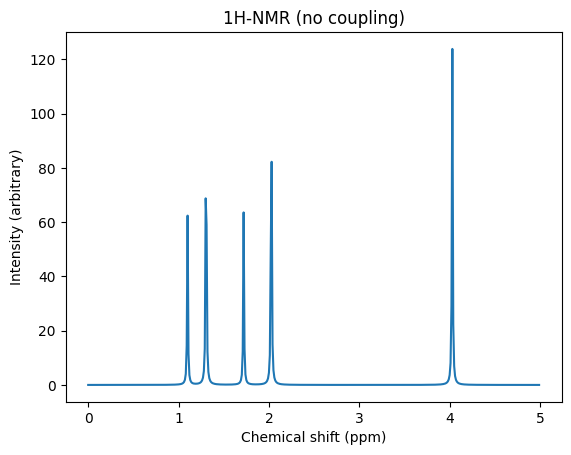

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scm.plams.tools.postprocess_results import broaden_results

sigma_ref_h = 31.7
shieldings = np.array(props["NMR Shieldings InputOrder"])

chemical_shifts = sigma_ref_h - np.array(shieldings)

x, y = broaden_results(
    chemical_shifts,
    areas=np.ones(chemical_shifts.shape),  # weigh all peaks equally
    broadening_width=0.01,
    broadening_type="lorentzian",
    x_data=(0, 5, 0.01),  # x range and resolution
)

fig, ax = plt.subplots()
ax.set_title("1H-NMR (no coupling)")
ax.set_xlabel("Chemical shift (ppm)")
ax.set_ylabel("Intensity (arbitrary)")
ax.plot(x, y);

## Conclusion

In this Python example you learned how to set up and run the NMR calculation.

For more detailed analysis, including multiplet splitting (coupling), see the GUI tutorial.

**Recommendation**: Use AMSspectra for further analysis.